<h1><b>Autonomous Driving</b></h1>

<h3><b> PART 1 </b></h3>

<h3><b><font color='blue'>1. Presetting environment</font></b></h3>
<ol>
<li>This project is done on Google colab.</li>
<li>Mounting Google Drive. </li>
<li>Setting label and image paths.</li>
</ol>

In [ ]:
#Mounting google drive for dataset access
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Setting label and image path
label_path = "/content/drive/MyDrive/AutonomousDriving/Part1/labels.csv"
image_path = "/content/drive/MyDrive/AutonomousDriving/Part1/Images"

<h3><b><font color='blue'>2 Importing all necessary libraries</font></b></h3>

In [ ]:
#Loading all module required for this project
import pandas as pd
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers

<h3><b><font color='blue'>3. Loading datasets from google drive</font></b></h3>

In [ ]:
#Reading labels from csv file. The labels.csv file has cordinates of an objects in given image.
labels_df = pd.read_csv(label_path)

In [ ]:
#Checking first 5 rows of labels file
labels_df.head()

,00000000,pickup_truck,213,34,255,50
0,0,car,194,78,273,122
1,0,car,155,27,183,35
2,0,articulated_truck,43,25,109,55
3,0,car,106,32,124,45
4,1,bus,205,155,568,314


In [ ]:
#Assigning column name for the labels
labels_df = pd.read_csv(label_path, sep=",", header=None)
labels_df.columns = ['image_id', 'class', 'x_min', 'y_min', 'x_max', 'y_max']
#Changing the image_id into 8 digit format
labels_df['image_id'] = labels_df['image_id'].apply(lambda x: f"{x:08d}")
labels_df.head()

,image_id,class,x_min,y_min,x_max,y_max
0,00000000,pickup_truck,213,34,255,50
1,00000000,car,194,78,273,122
2,00000000,car,155,27,183,35
3,00000000,articulated_truck,43,25,109,55
4,00000000,car,106,32,124,45


In [ ]:
#Printing number of row/entries in labels.csv file
labels_df.shape

(351549, 6)

<b><font color='green'>Inference</font></b>

<ol>
<li>Label file is not having any column heading, so assigned name for column.</li>
<li>351548 records are present in labels.csv file and 6 columns.</li> <li>This files has cordinates details of an object in an image. The images are distinguished by its image_id.</li>
</ol>

<h3><b><font color='blue'>4. Loading Images. Resizing Image and Boundary Box for consistency </font></b></h3>

In [ ]:
#Counting number of images in the dataset
print("Number of images in the dataset:", len(os.listdir(image_path)))

Number of images in the dataset: 5626


<mark>Note:</mark> Due to compute limitation, training model with 10,000 labels

In [ ]:
# Use iloc to pick the first 10000 labels
label_subset_df = labels_df.iloc[:10000]
label_subset_df

,image_id,class,x_min,y_min,x_max,y_max
0,00000000,pickup_truck,213,34,255,50
1,00000000,car,194,78,273,122
2,00000000,car,155,27,183,35
3,00000000,articulated_truck,43,25,109,55
4,00000000,car,106,32,124,45
...,...,...,...,...,...,...
9995,00003189,car,206,87,341,145
9996,00003190,pickup_truck,76,54,147,97
9997,00003190,pickup_truck,213,35,256,52
9998,00003190,car,155,26,182,36


In [ ]:
#Finding number of images used based on 10000 labels
imageid_max_counts = int(label_subset_df.iloc[9999]['image_id'])
imageid_max_counts

3191

In [ ]:
#Printing all images for which first 10000 labels are present.
for index in range(0, imageid_max_counts+1):
    img_path = os.path.join(image_path, f"{index:08d}.jpg")
    print(img_path)

/content/drive/MyDrive/AutonomousDriving/Part1/Images/00000000.jpg
/content/drive/MyDrive/AutonomousDriving/Part1/Images/00000001.jpg
/content/drive/MyDrive/AutonomousDriving/Part1/Images/00000002.jpg
/content/drive/MyDrive/AutonomousDriving/Part1/Images/00000003.jpg
/content/drive/MyDrive/AutonomousDriving/Part1/Images/00000004.jpg
/content/drive/MyDrive/AutonomousDriving/Part1/Images/00000005.jpg
/content/drive/MyDrive/AutonomousDriving/Part1/Images/00000006.jpg
/content/drive/MyDrive/AutonomousDriving/Part1/Images/00000007.jpg
/content/drive/MyDrive/AutonomousDriving/Part1/Images/00000008.jpg
/content/drive/MyDrive/AutonomousDriving/Part1/Images/00000009.jpg
/content/drive/MyDrive/AutonomousDriving/Part1/Images/00000010.jpg
/content/drive/MyDrive/AutonomousDriving/Part1/Images/00000011.jpg
/content/drive/MyDrive/AutonomousDriving/Part1/Images/00000012.jpg
/content/drive/MyDrive/AutonomousDriving/Part1/Images/00000013.jpg
/content/drive/MyDrive/AutonomousDriving/Part1/Images/00000014

In [ ]:
#Finding different classes of the object from the label file
labels = label_subset_df['class'].to_numpy()
unique_labels = np.unique(labels)
print("Total classes of vehicle:", unique_labels)
print("\n Total category of vehicles:", unique_labels.size)

Total classes of vehicle: ['articulated_truck' 'bicycle' 'bus' 'car' 'motorcycle'
 'motorized_vehicle' 'non-motorized_vehicle' 'pedestrian' 'pickup_truck'
 'single_unit_truck' 'work_van']

 Total category of vehicles: 11


In [ ]:
#Creating bounding box arrary
bounding_boxes = label_subset_df[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
print("Bounding Box: \n", bounding_boxes)
print("\nShape of bounding box:", bounding_boxes.shape)

Bounding Box: 
 [[213  34 255  50]
 [194  78 273 122]
 [155  27 183  35]
 ...
 [213  35 256  52]
 [155  26 182  36]
 [  9 222 234 330]]

Shape of bounding box: (10000, 4)


In [ ]:
# Converting labels to one-hot encoding
label_to_index = {label: index for index, label in enumerate(unique_labels)}
index_to_label = {index: label for index, label in enumerate(unique_labels)}
labels = np.array([label_to_index[label] for label in labels])
labels

array([8, 3, 3, ..., 8, 3, 3])

In [ ]:
#Loading image
images = []
image_size = (224, 224)  # Example target size (width, height)

for index, row in label_subset_df.iterrows():
    img_path = os.path.join(image_path, f"{row['image_id']}.jpg")
    img = cv2.imread(img_path)

    if img is not None:
        # Resize the image to a consistent size
        img_resized = cv2.resize(img, image_size)
        images.append(img_resized)
        #Resize of bounding box consistent size
        x = img.shape[1]
        y = img.shape[0]
        bounding_boxes[index, [0, 2]] = bounding_boxes[index, [0, 2]] * (float(224/x))
        bounding_boxes[index, [1, 3]] = bounding_boxes[index, [1, 3]] * (float(224/y))
    else:
        print(f"Error loading image: {img_path}")

# Converting list of images to a NumPy array
images = np.array(images)

In [ ]:
print("After resizing image shape:",images.shape)
print("\nAfter resizing Bounding Box: \n", bounding_boxes)
print("\nAfter resizing shape of bounding box: \n", bounding_boxes.shape)

After resizing image shape: (10000, 224, 224, 3)

After resizing Bounding Box: 
 [[139  33 167  49]
 [127  76 178 119]
 [101  26 119  34]
 ...
 [139  34 167  51]
 [101  25 119  35]
 [  2 103  72 154]]

After resizing shape of bounding box: 
 (10000, 4)


<b><font color='green'>Inference</font></b>

<ol>
<li>Number of images in the dataset: 5626. Total images used for trainig 3192</li>
<li>Total category of vehicle: 11</li>
<li>Shape of bounding box: 10000, 4.</li>
</ol>

<h3><b><font color='blue'>5. Resizing image and spliting data for training and testing</font></b></h3>

In [ ]:
#Spliting the dataset (Images, Labels and Bounding_box) into train and test.
X_train, X_test, y_train, y_test, bbox_train, bbox_test = train_test_split(images, labels, bounding_boxes, test_size=0.2, random_state=42)

<h3><b><font color='blue'>6. Creating CNN model with Vechile Class and Bounding Box as Output layer</font></b></h3>

In [ ]:
def create_model(input_shape, num_classes):
    #Input layers
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    #Flatting into single dimension for faster processing
    x = layers.Flatten()(x)
    #Fully connected dense neural network
    x = layers.Dense(64, activation='relu')(x)
    #Output layers
    vehicle_class = layers.Dense(num_classes, activation='softmax', name='vehicle_class')(x)
    bounding_box = layers.Dense(4, name='bounding_box')(x)
    #Preparing model with input and output layer
    model = keras.Model(inputs=inputs, outputs=[vehicle_class, bounding_box])
    return model

In [ ]:
#Preparing input value for model and calling model create function
#input_shape = processed_images[0].shape
input_shape = images[0].shape
print(input_shape)
num_classes = len(unique_labels)
model = create_model(input_shape, num_classes)

(224, 224, 3)


In [ ]:
#Summary of the CNN Model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 222, 222, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 111, 111, 32)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 54, 54, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 52, 52, 64)     │         36,928 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 173056)         │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │     11,075,648 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vehicle_class (Dense)     │ (None, 11)             │            715 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bounding_box (Dense)      │ (None, 4)              │            260 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,132,943 (42.47 MB)

 Trainable params: 11,132,943 (42.47 MB)

 Non-trainable params: 0 (0.00 B)

<h3><b><font color='blue'>7. Compling the model</font></b></h3>

In [ ]:
#Compiling the model.
#Optimizer 'Adam' is user
#Loss function for output layer vehicle class is sparse categorical cross entropy for classification.
#Loss function for output layer bounding box is Mean Absolute Error as the output is numeric.
#Accuracy and Mean Absolute Error is used to measure the output
model.compile(optimizer='adam',
              loss={'vehicle_class': 'sparse_categorical_crossentropy', 'bounding_box': 'mse'},
              metrics={'vehicle_class': 'accuracy', 'bounding_box': 'mae'})

<h3><b><font color='blue'>8. Training the model</font></b></h3>

In [ ]:
#Training the model.
#Epoch is 10 and Batch-Size is 64
history = model.fit(X_train, {'vehicle_class': y_train, 'bounding_box': bbox_train},
          epochs=10, batch_size=64,
          validation_data=(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}))

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 838s 7s/step - bounding_box_mae: 167.5871 - loss: 324296.3438 - vehicle_class_accuracy: 0.1307 - val_bounding_box_mae: 43.1839 - val_loss: 2966.9092 - val_vehicle_class_accuracy: 0.5845
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 848s 7s/step - bounding_box_mae: 40.6006 - loss: 2640.7368 - vehicle_class_accuracy: 0.5105 - val_bounding_box_mae: 39.8839 - val_loss: 2581.3115 - val_vehicle_class_accuracy: 0.5930
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 861s 7s/step - bounding_box_mae: 39.7341 - loss: 2529.2368 - vehicle_class_accuracy: 0.4989 - val_bounding_box_mae: 40.1522 - val_loss: 2647.0095 - val_vehicle_class_accuracy: 0.5170
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 830s 6s/step - bounding_box_mae: 38.2823 - loss: 2370.1208 - vehicle_class_accuracy: 0.5153 - val_bounding_box_mae: 41.8524 - val_loss: 2895.1565 - val_vehicle_class_accuracy: 0.4670
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 787s 6s/step - bounding_box_mae: 38.5789 - loss: 2421.6941 - vehi

<b><font color='green'>Inference</font></b>

<ol>
<li>Model was trained with 10 iteration, the batch size used was 64.</li>
<li>Vehicle Class Accuracy on validation data increased to 0.6260 after 10 epoch.</li>
<li>Bounding Box Mean Absolute Error reduced to 41.2407.</li>
</ol>

<h3><b><font color='blue'>9. Predicting vehical class and boundary box for a sample image using model trained in previous step</font></b></h3>

<h4><font color='blue'>Taking random image for testing</font></h4>

In [ ]:
# Taking a random sample image to test
# using model.predict
sample_images = X_test[[2]]
# Perform inference on the sample images
predictions = model.predict(sample_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


array([[[ 20,   9,   3],
        [ 20,   8,   3],
        [ 14,   3,   1],
        ...,
        [  9,   7,   7],
        [ 17,  15,  15],
        [  8,   6,   6]],

       [[ 23,  11,   9],
        [ 75,  63,  57],
        [ 92,  80,  74],
        ...,
        [ 36,  32,  32],
        [  8,   5,   5],
        [  8,   5,   5]],

       [[ 63,  51,  45],
        [196, 184, 178],
        [238, 227, 220],
        ...,
        [ 69,  63,  64],
        [  5,   0,   1],
        [ 14,   9,  10]],

       ...,

       [[ 11,   6,   7],
        [ 46,  41,  41],
        [ 53,  48,  49],
        ...,
        [ 53,  44,  41],
        [ 15,   6,   4],
        [ 12,   5,   3]],

       [[ 11,   6,   7],
        [ 45,  40,  41],
        [ 53,  48,  49],
        ...,
        [ 53,  44,  41],
        [ 15,   6,   4],
        [ 12,   5,   3]],

       [[ 11,   6,   7],
        [ 45,  40,  41],
        [ 53,  48,  49],
        ...,
        [ 53,  44,  41],
        [ 15,   6,   4],
        [ 12,   5,   3]]], dtype=uint8)
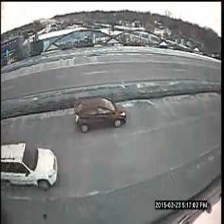

In [ ]:
#Sample image used of testing
sample_image = X_test[2]
sample_image

In [ ]:
#All the classes of object used for classification
unique_labels

array(['articulated_truck', 'bicycle', 'bus', 'car', 'motorcycle',
       'motorized_vehicle', 'non-motorized_vehicle', 'pedestrian',
       'pickup_truck', 'single_unit_truck', 'work_van'], dtype=object)

In [ ]:
# Extract the predicted bounding box coordinates
#predicted_bounding_boxes = predictions[1]
#predicted_bounding_boxes
print(f"Prediction of class in an image is:\n {predictions[0]}")
print(f"\n Prediction of boundary box in an image is:\n {predictions[1]}")

Prediction of class in an image is:
 [[1.6914237e-04 1.8289120e-06 1.8101130e-02 8.0195379e-01 1.8449647e-07
  7.2705999e-02 4.7649913e-03 3.1530626e-02 6.7228720e-02 1.3967004e-08
  3.5436081e-03]]

 Prediction of boundary box in an image is:
 [[ 71.47537  95.15862 111.4915  118.9802 ]]


<h4><font color='blue'> Plotting the prediction for an image</font></h4>

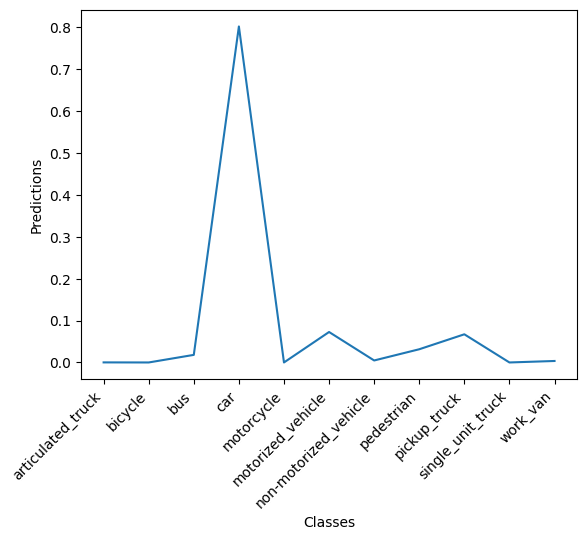

In [ ]:
import matplotlib.pyplot as plt

# Rotateting x-axis labels
plt.xticks(rotation=45, ha='right')

# Plotting the graph
plt.plot(unique_labels, predictions[0][0])

# Setting labels
plt.xlabel("Classes")
plt.ylabel("Predictions")

# Showing the plot
plt.show()


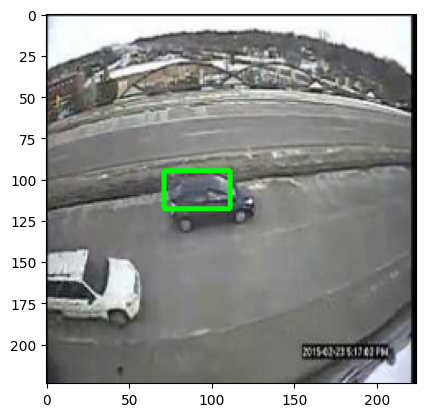

In [ ]:
# Extracting the predicted bounding box
predicted_bounding_boxes = predictions[1]

# Getting the image and scaling the bounding box coordinates to the image size
image_height, image_width, _ = sample_image.shape

# Scale predicted bounding box from [0,1] to image dimensions
x_min, y_min, x_max, y_max = predicted_bounding_boxes[0]

# Drawing the bounding box on the image
cv2.rectangle(sample_image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

# Display the image with the bounding box
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.show()


<h4><font color='blue'>Taking one more random image for testing</font> </h4>

In [ ]:
# Taking a random sample image to test
# using model.predict

sample_images = X_test[[614]]
# Perform inference on the sample images
predictions = model.predict(sample_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


array([[[ 1,  1,  1],
        [ 1,  1,  1],
        [ 3,  3,  3],
        ...,
        [ 8,  2,  4],
        [ 1,  0,  6],
        [ 0,  0,  8]],

       [[ 0,  0,  0],
        [ 8,  8,  8],
        [ 5,  5,  5],
        ...,
        [18, 11, 13],
        [ 2,  0,  5],
        [ 0,  0,  8]],

       [[ 6,  6,  6],
        [26, 26, 26],
        [29, 29, 29],
        ...,
        [38, 28, 28],
        [ 4,  1,  3],
        [ 0,  0,  6]],

       ...,

       [[ 9,  7,  6],
        [41, 37, 33],
        [52, 45, 37],
        ...,
        [ 4,  8,  8],
        [ 0,  2,  1],
        [ 0,  2,  1]],

       [[ 9,  7,  6],
        [41, 37, 33],
        [51, 44, 36],
        ...,
        [ 4,  8,  7],
        [ 0,  2,  1],
        [ 0,  2,  1]],

       [[ 9,  7,  6],
        [40, 37, 33],
        [50, 44, 36],
        ...,
        [ 4,  8,  8],
        [ 0,  2,  1],
        [ 0,  2,  1]]], dtype=uint8)
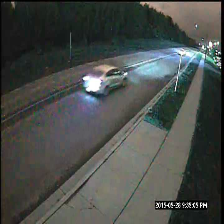

In [ ]:
#Sample image used of testing
sample_image = X_test[614]
sample_image

In [ ]:
# Extract the predicted bounding box coordinates
#predicted_bounding_boxes = predictions[1]
#predicted_bounding_boxes
print(f"Prediction of class in an image is:\n {predictions[0]}")
print(f"\n Prediction of boundary box in an image is:\n {predictions[1]}")

Prediction of class in an image is:
 [[5.37119657e-02 3.29569527e-09 1.23326510e-01 6.11888766e-01
  1.76957528e-05 1.39009282e-01 1.48602985e-02 4.30709071e-04
  5.66848479e-02 6.98637523e-05 1.14630534e-18]]

 Prediction of boundary box in an image is:
 [[106.636406  47.7351   144.66412   92.29855 ]]


<h4><font color='blue'> Plotting 2nd test image prediction</font></h4>

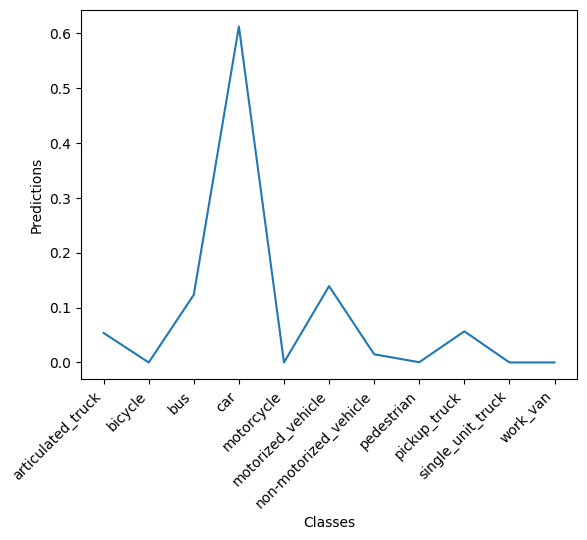

In [ ]:
import matplotlib.pyplot as plt

# Rotateting x-axis labels
plt.xticks(rotation=45, ha='right')

# Plotting the graph
plt.plot(unique_labels, predictions[0][0])

# Setting labels
plt.xlabel("Classes")
plt.ylabel("Predictions")

# Showing the plot
plt.show()

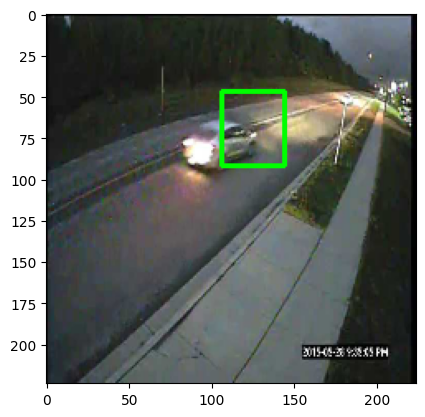

In [ ]:
# Extracting the predicted bounding box
predicted_bounding_boxes = predictions[1]

# Getting the image and scaling the bounding box coordinates to the image size
image_height, image_width, _ = sample_image.shape

# Scale predicted bounding box from [0,1] to image dimensions
x_min, y_min, x_max, y_max = predicted_bounding_boxes[0]

# Drawing the bounding box on the image
cv2.rectangle(sample_image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

# Display the image with the bounding box
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.show()


<b><font color='green'>Inference</font></b>

<ul>
<li> For the tested sample images, the model is predicting object
almost correctly and was able draw the boundary box as well.</li>
<li> Training on larger labels and images can help model to improve object detection and boundary prediction.</li>
</ul>

-------------------------------End of PART 1-----------------------
----------------

<h3><b>PART 2</b></h3>

<h4><b><font color='blue'>1. Importing all necessary libraries and setting dataset path</font></b></h4>

In [ ]:
#Loading all module required for this project
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers

In [ ]:
#Setting dataset path
tesla_death_filepath = "/content/drive/MyDrive/AutonomousDriving/Part2/Tesla - Deaths.csv"

<h4><b><font color='blue'>2. Preliminary data inspection and cleaning</font></b></h4>

In [ ]:
#Reading CSV file
tesla_df = pd.read_csv(tesla_death_filepath)
tesla_df.head()

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,...,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO,Unnamed: 16,Unnamed: 17,Source,Note,Deceased 1,Deceased 2,Deceased 3,Deceased 4
0,294.0,2022.0,1/17/2023,USA,CA,Tesla crashes into back of semi,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230118162813/ht...,NaN,NaN,NaN,NaN,NaN
1,293.0,2022.0,1/7/2023,Canada,-,Tesla crashes,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230109041434/ht...,NaN,Taren Singh Lal,NaN,NaN,NaN
2,292.0,2022.0,1/7/2023,USA,WA,"Tesla hits pole, catches on fire",1.0,-,1,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230107232745/ht...,NaN,NaN,NaN,NaN,NaN
3,291.0,2022.0,12/22/2022,USA,GA,Tesla crashes and burns,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,NaN,NaN,NaN,NaN,NaN
4,290.0,2022.0,12/19/2022,Canada,-,Tesla crashes into storefront,1.0,-,-,-,...,-,-,https://web.archive.org/web/20221223203725/ht...,https://web.archive.org/web/20221223203725/ht...,https://web.archive.org/web/20221223203725/ht...,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Checking for datatypes
tesla_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 24 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Case #                                                                294 non-null    float64
 1   Year                                                                  294 non-null    float64
 2   Date                                                                  294 non-null    object 
 3    Country                                                              294 non-null    object 
 4    State                                                                294 non-null    object 
 5    Description                                                          295 non-null    object 
 6    Deaths                                                               299 non-null    float64
 7  

<h4><font color='green'><b>Observation:</b><br>
Columns names are having white spaces. Need to remove white space for consistency.</font></h4>

In [ ]:
#Removing spaces from column name
new_columns = []
for column in tesla_df.columns:
  new_columns.append(column.strip())
tesla_df.columns = new_columns
#Columns name after removing spaces
tesla_df.columns

Index(['Case #', 'Year', 'Date', 'Country', 'State', 'Description', 'Deaths',
       'Tesla driver', 'Tesla occupant', 'Other vehicle', 'Cyclists/ Peds',
       'TSLA+cycl / peds', 'Model', 'Autopilot claimed',
       'Verified Tesla Autopilot Deaths',
       'Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO',
       'Unnamed: 16', 'Unnamed: 17', 'Source', 'Note', 'Deceased 1',
       'Deceased 2', 'Deceased 3', 'Deceased 4'],
      dtype='object')

In [ ]:
print("After correcting column name:\n")
tesla_df.info()

After correcting column name:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 24 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Case #                                                              294 non-null    float64
 1   Year                                                                294 non-null    float64
 2   Date                                                                294 non-null    object 
 3   Country                                                             294 non-null    object 
 4   State                                                               294 non-null    object 
 5   Description                                                         295 non-null    object 
 6   Deaths                                                              299 non-null   

In [ ]:
#Finding number of cases
tesla_df['Case #'].count()

294

In [ ]:
#Slicing and creating new dataframe with all valid rows (i.e. 0-293)
tesla = tesla_df.iloc[:294]

In [ ]:
#Finding number of duplicate cases
tesla['Case #'].duplicated().sum()

0

In [ ]:
duplicate_row = tesla[tesla.duplicated()]
duplicate_row

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,...,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO,Unnamed: 16,Unnamed: 17,Source,Note,Deceased 1,Deceased 2,Deceased 3,Deceased 4


<h4><font color='green'><b>Inference:</b>
<ol>
<li>Total 294 rows.</li>
<li>Every row has different 'Case' number. No Duplicate entry found.</li>
</ol>
</font></h4>

<h5> Finding all Missing/NA values and filling it with 0.</h5>

In [ ]:
#Filling all empty places with 0
for column in tesla.columns:
  tesla.loc[:, column] = tesla.loc[:, column].replace(' - ', 0)
  tesla.loc[:, column] = tesla.loc[:, column].replace('-', 0)
tesla.head()

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,...,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO,Unnamed: 16,Unnamed: 17,Source,Note,Deceased 1,Deceased 2,Deceased 3,Deceased 4
0,294.0,2022.0,1/17/2023,USA,CA,Tesla crashes into back of semi,1.0,1,0,0,...,0,0,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230118162813/ht...,NaN,NaN,NaN,NaN,NaN
1,293.0,2022.0,1/7/2023,Canada,0,Tesla crashes,1.0,1,0,0,...,0,0,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230109041434/ht...,NaN,Taren Singh Lal,NaN,NaN,NaN
2,292.0,2022.0,1/7/2023,USA,WA,"Tesla hits pole, catches on fire",1.0,0,1,0,...,0,0,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230107232745/ht...,NaN,NaN,NaN,NaN,NaN
3,291.0,2022.0,12/22/2022,USA,GA,Tesla crashes and burns,1.0,1,0,0,...,0,0,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,NaN,NaN,NaN,NaN,NaN
4,290.0,2022.0,12/19/2022,Canada,0,Tesla crashes into storefront,1.0,0,0,0,...,0,0,https://web.archive.org/web/20221223203725/ht...,https://web.archive.org/web/20221223203725/ht...,https://web.archive.org/web/20221223203725/ht...,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Finding any NAN count for each column
isna_result = tesla.isna().sum()
isna_result

,0
Case #,0
Year,0
Date,0
Country,0
State,0
Description,0
Deaths,0
Tesla driver,5
Tesla occupant,9
Other vehicle,4


In [ ]:
#Filling all NAN with 0
for index, value in enumerate(isna_result):
  if value != 0:
    tesla.loc[:, tesla.columns[index]] = tesla.loc[:, tesla.columns[index]].fillna(0)

In [ ]:
#After filling all NAN with 0
isna_result = tesla.isna().sum()
isna_result

,0
Case #,0
Year,0
Date,0
Country,0
State,0
Description,0
Deaths,0
Tesla driver,0
Tesla occupant,0
Other vehicle,0


In [ ]:
#Describing all numberical data
tesla.describe()

,Case #,Year,Deaths,Deceased 4
count,294.000000,294.000000,294.000000,294.0
mean,147.500000,2013.850340,1.200680,0.0
std,85.014705,106.050207,0.513171,0.0
min,1.000000,202.000000,1.000000,0.0
25%,74.250000,2019.000000,1.000000,0.0
50%,147.500000,2021.000000,1.000000,0.0
75%,220.750000,2022.000000,1.000000,0.0
max,294.000000,2022.000000,4.000000,0.0


In [ ]:
#Dropping non-relavent columns for analysis
tesla = tesla.drop(columns=['Source', 'Note', 'Unnamed: 16', 'Unnamed: 17', 'Deceased 1', 'Deceased 2', 'Deceased 3','Deceased 4'])
tesla.head()

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
0,294.0,2022.0,1/17/2023,USA,CA,Tesla crashes into back of semi,1.0,1,0,0,0,1,0,0,0,0
1,293.0,2022.0,1/7/2023,Canada,0,Tesla crashes,1.0,1,0,0,0,1,0,0,0,0
2,292.0,2022.0,1/7/2023,USA,WA,"Tesla hits pole, catches on fire",1.0,0,1,0,0,1,0,0,0,0
3,291.0,2022.0,12/22/2022,USA,GA,Tesla crashes and burns,1.0,1,0,0,0,1,0,0,0,0
4,290.0,2022.0,12/19/2022,Canada,0,Tesla crashes into storefront,1.0,0,0,0,1,1,0,0,0,0


<h3><b><font color='blue'>2. Exploratory Data Analysis (EDA) </font></b></h3>





<u>Question a:</u>
Perform an in-depth exploratory data analysis on the number of events by date, per year, and per day for each state and country

<h4> Number of events by date: </h4>

In [ ]:
#Converting type of 'Date' column from object type to Datatime type
tesla['Date'] = pd.to_datetime(tesla['Date'])
#Cases recorded by date
tesla['Date'].value_counts()

,count
Date,
2022-05-28,3
2022-06-20,3
2019-11-20,3
2021-07-26,2
2021-04-17,2
...,...
2021-08-17,1
2021-07-23,1
2021-07-21,1


<h4> Number of events per year: </h4>

In [ ]:
#Cases recorded per year
tesla["Year"].value_counts()

,count
Year,
2022.0,95
2021.0,58
2019.0,46
2020.0,39
2018.0,18
2016.0,15
2017.0,11
2015.0,5
2014.0,4


<h4><font color='green'><b>Observation:</b><br>
One entry in year is found as 202, which seem invalid so treating as a outliner and correcting it with checking the Date column value.</font></h4>

In [ ]:
#Find the row with outliner year '202'
tesla[tesla["Year"] == 202]

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
162,132.0,202.0,2020-09-17,USA,GA,"Car loses control, hits bus shelter",1.0,0,0,0,1,1,3,1,0,1


In [ ]:
#Correcting the 'Year' for this entry based on 'Date' columns
tesla.loc[tesla["Year"] == 202, "Year"] = 2020
tesla.iloc[[162]]

,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,Cyclists/ Peds,TSLA+cycl / peds,Model,Autopilot claimed,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO
162,132.0,2020.0,2020-09-17,USA,GA,"Car loses control, hits bus shelter",1.0,0,0,0,1,1,3,1,0,1


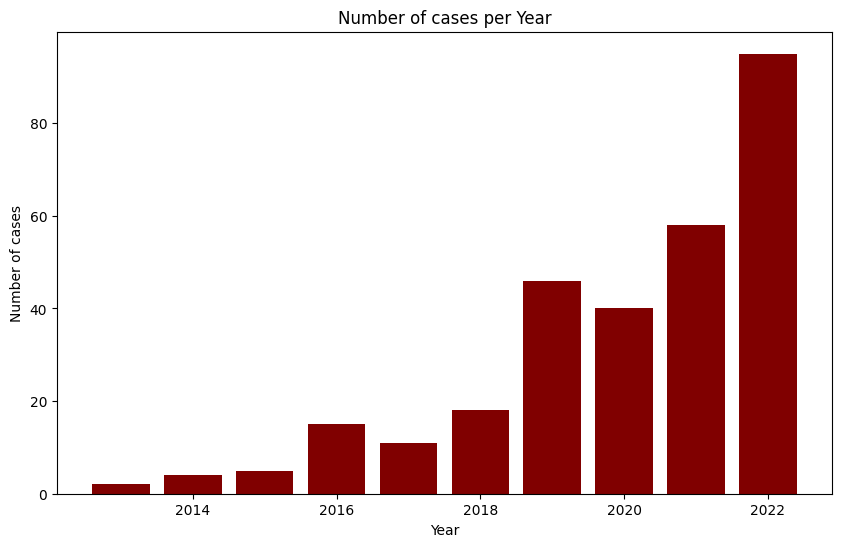

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(tesla["Year"].value_counts().index, tesla["Year"].value_counts().values, color = 'maroon')
plt.title("Number of cases per Year")
plt.xlabel("Year")
plt.ylabel("Number of cases")
plt.show()

<h4> Number of events per day for each state and country: </h4>

In [ ]:
#Cases per day for each state and country
tesla.groupby(['Country', 'State', 'Date'])['Case #'].count()

Country      State  Date      
 Australia   0      2017-11-14    1
                    2022-05-12    1
 Austria     0      2019-11-20    1
 Belgium     0      2020-10-07    1
                    2021-03-20    1
                                 ..
 USA         SC     2022-08-23    1
                    2022-09-18    1
             UT     2022-07-24    1
             WA     2023-01-07    1
 Ukraine     0      2019-06-07    1
Name: Case #, Length: 290, dtype: int64

In [ ]:
#Finding cases by country
tesla.groupby(['Country'])['Case #'].count()

,Case #
Country,
Australia,2
Austria,1
Belgium,2
Canada,10
China,16
Denmark,2
Finland,1
France,2
Germany,11


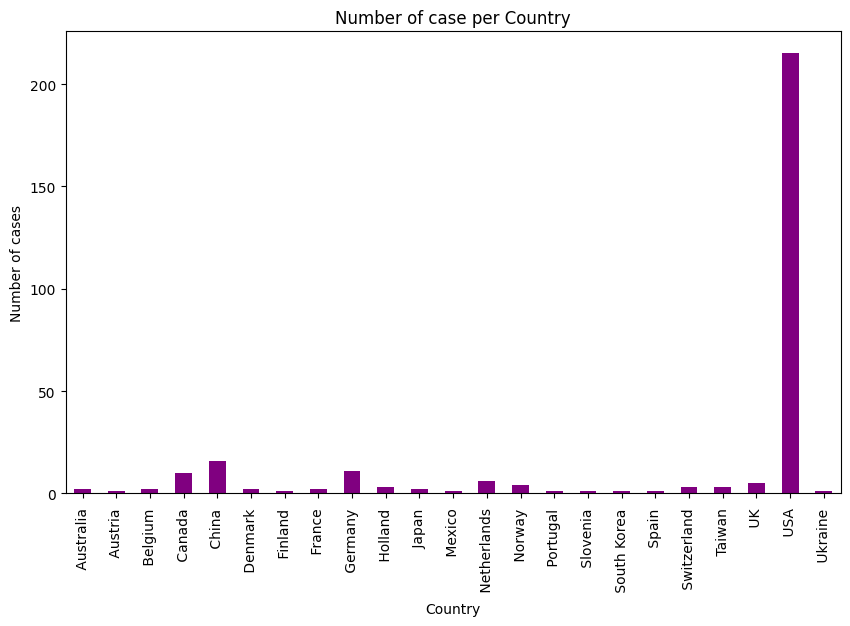

In [ ]:
plt.figure(figsize=(10, 6))
tesla.groupby(['Country'])['Case #'].count().plot(kind='bar', color = 'purple')
plt.title("Number of case per Country")
plt.xlabel("Country")
plt.ylabel("Number of cases")
plt.show()

<h4><font color='green'><b>Inference:</b>
<ol>
<li>Maximum cases were reported in year 2022</li>
<li>Maximum cases were reported in USA.</li>
</ol>
</font></h4>

Question:
b. Analyze the different aspects of the death events. For example:

*   What is the number of victims (deaths) in each accident?
*   What is the proportion of events in which one or more occupants died?
*   What is the distribution of events in which the vehicle hit a cyclist or a pedestrian?
*   How many times did the accident involve the death of an occupant or driver of a Tesla along with a cyclist or pedestrian?
*   What is the frequency of Tesla colliding with other vehicles?

What is the number of victims (deaths) in each accident?

In [ ]:
#The number of victims (deaths) in each accident
tesla[['Case #', 'Deaths']].groupby('Case #').sum()

,Deaths
Case #,
1.0,2.0
2.0,1.0
3.0,3.0
4.0,1.0
5.0,1.0
...,...
290.0,1.0
291.0,1.0
292.0,1.0


What is the proportion of events in which one or more occupants died?

In [ ]:
#The proportion of events in which one or more occupants died
print(f"Proportion of events in which one or more occupants died:\033[1m {tesla[tesla['Deaths'] >= 1]['Case #'].count()} \033[0m")

Proportion of events in which one or more occupants died: 294 


What is the distribution of events in which the vehicle hit a cyclist or a pedestrian?

In [ ]:
#The distribution of events in which the vehicle hit a cyclist or a pedestrian.
#Changing the column 'Cyclists/ Peds' datatype to int.
tesla['Cyclists/ Peds'] = tesla['Cyclists/ Peds'].astype(int)
print(f"The distribution of events in which the vehicle hit a cyclist or a pedestrian:\033[1m {tesla[tesla['Cyclists/ Peds'] >= 1]['Case #'].count()} \033[0m")

The distribution of events in which the vehicle hit a cyclist or a pedestrian: 44 


How many times did the accident involve the death of an occupant or driver of a Tesla along with a cyclist or pedestrian?

In [ ]:
#Number of times accident involved the death of an occupant or driver of a Tesla along with a cyclist or pedestrian.
#Changing the column 'Tesla occupant' & 'Tesla driver' datatype to int.
tesla['Tesla occupant'] = tesla['Tesla occupant'].astype(int)
tesla['Tesla driver'] = tesla['Tesla driver'].astype(int)
print(f"Number of times accident involved the death of an occupant or driver of a Tesla along with a cyclist or pedestrian:\033[1m {tesla[((tesla['Tesla occupant'] >= 1) | (tesla['Tesla driver'] >= 1)) & (tesla['Cyclists/ Peds'] >= 1)]['Case #'].count()} \033[0m")

Number of times accident involved the death of an occupant or driver of a Tesla along with a cyclist or pedestrian: 1 


What is the frequency of Tesla colliding with other vehicles?

In [ ]:
#The frequency of Tesla colliding with other vehicles
#Changing the column 'Other vehicle' datatype to int.
tesla['Other vehicle'] = tesla['Other vehicle'].astype(int)
print(f"Frequency of Tesla colliding with other vehicles:\033[1m {tesla[tesla['Other vehicle'] >= 1]['Other vehicle'].sum()} \033[0m")

Frequency of Tesla colliding with other vehicles: 130 


Question c:<br>

*   Study the event distribution across models



In [ ]:
#Filtering-out all the rows which does not have the model value
tesla_c = tesla[tesla['Model'] != 0]
#Find different model types
tesla_c['Model'].unique()

array([' Y ', '  1 ', '  2 ', '  3 ', ' S ', ' X '], dtype=object)

In [ ]:
#Count of Model based on cases
tesla_c['Model'].value_counts()

,count
Model,
S,45
3,39
X,17
Y,10
1,1
2,1


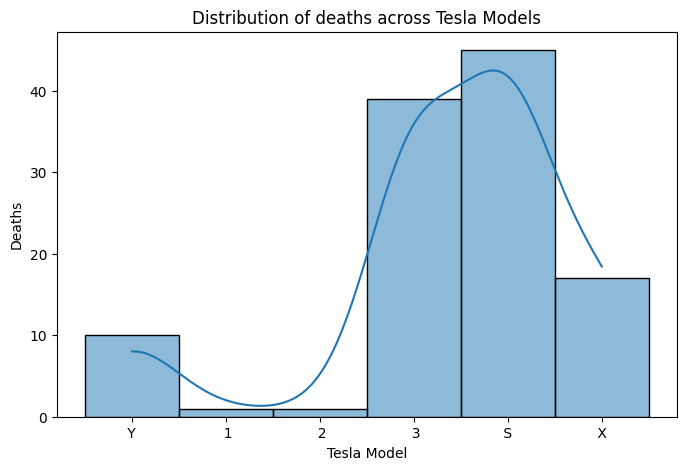

In [ ]:
#Plotting graph to see which Model has most cases reported.

# Creating the distribution graph
plt.figure(figsize=(8, 5))  # Adjust figure size as needed
sns.histplot(tesla_c['Model'], kde=True)
plt.title('Distribution of deaths across Tesla Models')
plt.xlabel('Tesla Model')
plt.ylabel('Deaths')
plt.show()

Question d:<br> Check the distribution of verified Tesla autopilot deaths

In [ ]:
col_name = 'Verified Tesla Autopilot Deaths'
#Converting the datatype of the column 'Verified Tesla Autopilot Deaths' to int.
tesla[col_name] = tesla[col_name].astype(int)
#Filtering-out all rows for which the 'Verified Tesla Autopilot Deaths' is not present.
tesla_va = tesla.loc[tesla[col_name] != 0]
#Finding all categories for 'Verified Tesla Autopilot Deaths' column.
tesla_va[col_name].unique()

array([1, 2])

In [ ]:
#Finding the distribution of 'Verified Tesla Autopilot Deaths' across all its category.
tesla_va[col_name].value_counts()

,count
Verified Tesla Autopilot Deaths,
1,13
2,3


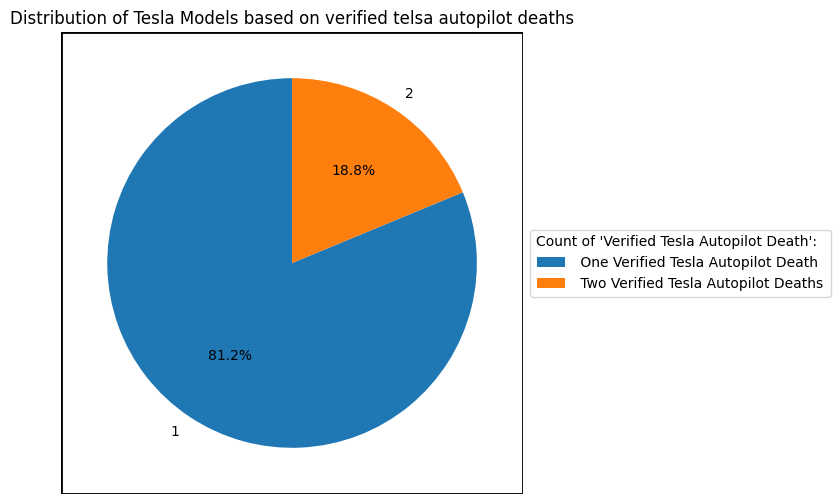

In [ ]:
#Plotting graph to visualize the 'Verified Tesla Autopilot Deaths' distribution across its category

labels = [" One Verified Tesla Autopilot Death", " Two Verified Tesla Autopilot Deaths"]

# Creating a pie-chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(tesla_va[col_name].value_counts(), labels = tesla_va[col_name].unique(), autopct='%1.1f%%', startangle=90)

# Adding a rectangle box around the pie chart
ax.add_patch(plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='black', lw=2, transform=ax.transAxes))

# Adding a legend
ax.legend(wedges, labels, title="Count of 'Verified Tesla Autopilot Death':  ", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Distribution of Tesla Models based on verified telsa autopilot deaths')
plt.show()

-------------------------------End of PART 2-----------------------
